## Title: Predicting Cleveland Heart Disease

#### Group 41 - DSCI100 Project Report - Rachel Smith, Emily Han, Selina Zhou, Junyue Xue 

### **1. Introduction**

Scientists aim to predict the presence of heart disease based on various medical attributes. This helps patients with heart disease receive proper treatment and minimizes the costly resources used on healthy patients. Thus, this project investigates the question: "Can age, serum cholesterol, and resting blood pressure measurements predict the presence of heart disease in males?" We will use the Heart Disease dataset, which contains 14 medical attributes for 303 individuals in Cleveland, Ohio. The num column indicates presence (categories 1-4) or absence (category 0) of heart disease, with 1-4 referring to different diseases. This project will combine categories 1-4 to focus on presence vs. absence, as some diseases are extremely rare (leading to unbalanced data). Once heart disease is detected, patients can receive further treatment to determine their specific disease.

### **2. Methods & Results**

#### **2.1. Loading Data**

We begin by downloading and tidying the Heart Disease dataset. Column names are assigned for readability, and factor columns are used for categorical variables. For clarity, Table 1 shows the first six rows of the 303 row tibble.

In [34]:
library(tidyverse)
library(repr)
library(tidymodels)
library(shiny)

url<-"https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
download.file(url,"cleveland_heart_disease.csv")
cleveland_data<-read_csv("cleveland_heart_disease.csv",col_names=FALSE)|>
rename(age=X1,sex=X2,cp=X3,trestbps=X4,chol=X5,fbs=X6,restecg=X7,thalach=X8,exang=X9,oldpeak=X10,slope=X11,ca=X12,thal=X13,num=X14)|>
    mutate(across(sex:cp,as_factor))|>
    mutate(across(fbs:restecg,as_factor))|>
    mutate(exang=as_factor(exang),slope=as_factor(slope),thal=as_factor(thal),num=as_factor(num))

h4("Table 1: First 6 Rows of Heart Disease Dataset")
head(cleveland_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Shiny tags cannot be represented in plain text (need html)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<chr>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


Column information for Table 1 is as follows:
* `age`: age of the patient (years)
* `sex`: sex (1=male, 0=female)
* `cp`: chest pain type (1=typical angina, 2=atypical angina, 3=non-anginal pain, 4=asymptomatic)
* `trestbps`: resting blood pressure, upon admission to hospital (mm Hg)
* `chol`: serum cholestoral (mg/dl)
* `fbs`: fasting blood sugar > 120 mg/dl (1=true, 0=false)
* `restecg`: resting electrocardiographic results (0=normal, 1=having abnormality, 2=showing left ventricular hypertrophy)
* `thalach`: maximum heart rate achieved
* `exang`: exercise induced angina (1=yes, 0=no)
* `oldpeak`: ST depression induced by exercise relative to rest
* `slope`: slope of the peak exercise ST segment (1=upsloping, 2=flat, 3=downsloping)
* `ca`: number of major vessels colored by fluoroscopy
* `thal`: 3=normal, 6=fixed defect, 7=reversable defect
* `num`: diagnosis of heart disease (0=absence, 1,2,3,4=presence)

#### **2.2. Choosing Predictors, Filtering Data, and Balancing Data**

*Choosing Predictors*

To choose predictors, we first removed all categorical predictors (factor columns) from the dataset due to the function of K-nearest neighbors. From the numerical options, studies have found a strong correlation between high serum cholesterol and high resting blood pressure with an increased risk of heart disease, leading us to choose chol and trestbps as two of our predictors (Franklin et al., 2001; Valentini & Parati, 2009; Jung et al., 2022). Age was chosen as a third predictor as studies show increasing age results in decreased heart function and higher chances of developing risk factors. This leads to increased risk of heart disease (Prabhathi et al., 2014).

Thalach was not chosen as those with elevated thalach typically already experience other factors such as high blood pressure. In addition, thalach is a relatively new risk factor that still needs to be studied (Perret-Guillaume et al., 2009). Oldpeaks was not used due to “established cardiovascular risk factors" being not associated with ST depression (Carlén et al., 2019).

*Filtering Data*

In terms of biological sex, we chose to filter for males, as females typically experience heart disease later than males and are also underrepresented in clinical trials. Males also have a higher risk of experiencing mortality and cardiovascular events due to a loss of myocardial mass as they age, whereas females have a low risk until postmenopause, suggesting that males are more researched and are easier to find and understand trends due to consistency of heart health decline (Prabhathi et al., 2014).

Below, this information is used to wrangle the data. Sex is filtered for males, and the predictor columns age, chol, and trestbps are selected alongside num (classification of heart disease diagnosis). The selected predictor columns contain no missing values. Further, categories 1-4 in the num column are combined to represent if heart disease is "present," and category 0 is renamed to "absent" for clarity.

In [35]:
#Filtering the data
filtered_data<-cleveland_data|>
    filter(sex==1)|>
    select(age,chol,trestbps,num)|>
    mutate(num=fct_recode(num,"Present"="1","Present"="2","Present"="3","Present"="4","Absent"="0"))
h4("Table 2: Filtered Dataset")
head(filtered_data)

#Finding the distribution of absent and present cases in filtered_data
summary_table<-filtered_data|>
    group_by(num)|>
    summarize(count=n())
h4("Table 3: Distribution of Absent and Present Cases in Filtered Dataset")
summary_table

Shiny tags cannot be represented in plain text (need html)

age,chol,trestbps,num
<dbl>,<dbl>,<dbl>,<fct>
63,233,145,Absent
67,286,160,Present
67,229,120,Present
37,250,130,Absent
56,236,120,Absent
63,254,130,Present


Shiny tags cannot be represented in plain text (need html)

num,count
<fct>,<int>
Absent,92
Present,114


Table 2 shows the first six rows of the filtered dataset, while Table 3 shows a summary table of the distribution of absent and present cases. Notably, this distribution is uneven, with a count of 114 and 92 for present and absent cases, respectively. This could create a biased prediction, as the K-nearest neighbor algorithm uses the classification of surrounding points to predict new points, meaning the algorithm will more likely pick the class that has more points. Thus, below, we balance the data to create a more accurate classification model (Timbers et al., 2022). The upsampled dataset’s distribution of absent and present cases is shown in Table 4.

In [36]:
#Loading in necessary libraries to balance the data
install.packages("themis")
library(themis) 
install.packages("kknn")
library(kknn)

#Balancing the data
set.seed(10)
balance_recipe <- recipe(num ~., data = filtered_data) |> 
step_upsample(num, over_ratio = 1, skip = FALSE) |> 
prep() 

h4("Table 4: Distribution of Absent and Present Cases in Upsampled Dataset")
upsampled_cleveland <- bake(balance_recipe, filtered_data)
upsampled_cleveland |> 
group_by(num) |> 
summarize(count = n()) 

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



Shiny tags cannot be represented in plain text (need html)

num,count
<fct>,<int>
Absent,114
Present,114


#### **2.3. Splitting the Data**

The data will be split into 75% training and 25% testing data, with training data being used to develop the classification model. We chose this split as it is an appropriate percent tradeoff for wanting to use a larger training data set to train an accurate model, while also needing a larger test data set to get an accurate performance evaluation (Timbers et al., 2022).

We begin by setting the seed in order to have reproducibility in our data, so we get the same result each time the code is run (Timbers et al., 2022)

In [37]:
set.seed(10)
data_split<-initial_split(upsampled_cleveland,prop=0.75,strata=num)
data_train<-training(data_split)
data_test<-testing(data_split)
h4("Table 5: First 6 Rows of Training Data")
head(data_train)

#Distribution of absent and present cases in the training data
distribution_num<-data_train|>
    group_by(num)|>
    summarize(count=n())
h4("Table 6: Distribution of Absent and Present Cases in Training Data")
distribution_num

Shiny tags cannot be represented in plain text (need html)

age,chol,trestbps,num
<dbl>,<dbl>,<dbl>,<fct>
51,222,100,Absent
43,211,110,Absent
70,245,156,Absent
45,308,128,Absent
52,325,120,Absent
42,240,120,Absent


Shiny tags cannot be represented in plain text (need html)

num,count
<fct>,<int>
Absent,85
Present,85


Table 5 shows the first six rows of the training data, while Table 6 shows its distribution of absent and present cases. Notably, creating training data from the upsampled dataset has resulted in balanced absent and present cases in the training data as well.

#### **2.4. Method and Exploratory Data Analysis**

Our data analysis will use the KNN classification method, as it is well suited for predicting categorical classes from numerical variables and easy to understand and use compared to other methods. The predicted attribute will be whether heart disease is "present" or "absent" in the patient. The predictors will include age, chol, and trestbps. After creating and testing the model, we will visualize the results by using a scatter plot with two predictors on the x and y axes and points coloured by their classification (presence or absence of heart disease).

For exploratory analysis, Table 7 shows the average of all three predictors for absent and present cases. The difference in values for each predictor suggests that we expect present cases to be found in patients with higher age, serum cholesterol, and resting blood pressure.

In [38]:
mean_predictors<-data_train|>
    group_by(num)|>
    summarize(avg_age=mean(age),avg_chol=mean(chol),avg_trestbps=mean(trestbps))
h4("Table 7: Average Age, Serum Cholesterol, and Resting Blood Pressure for Absent and Present Cases")
mean_predictors

Shiny tags cannot be represented in plain text (need html)

num,avg_age,avg_chol,avg_trestbps
<fct>,<dbl>,<dbl>,<dbl>
Absent,51.56471,235.3059,127.5529
Present,55.84706,244.4824,131.9647


Further, Figures 1-3 show the separate distribution of each predictor for present and absent cases. This visualizes the trend suggested by Table 6, in that we expect present cases to be found in patients with higher age, serum cholesterol, and resting blood pressure.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


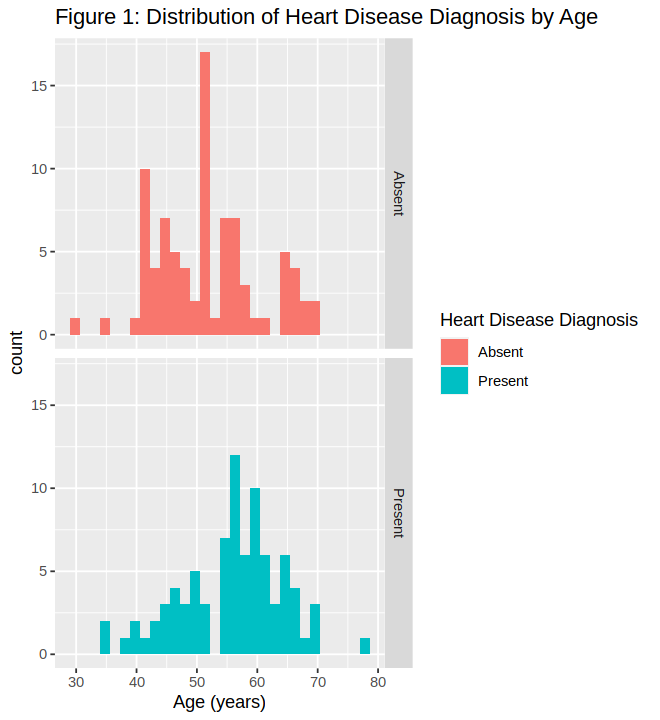

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


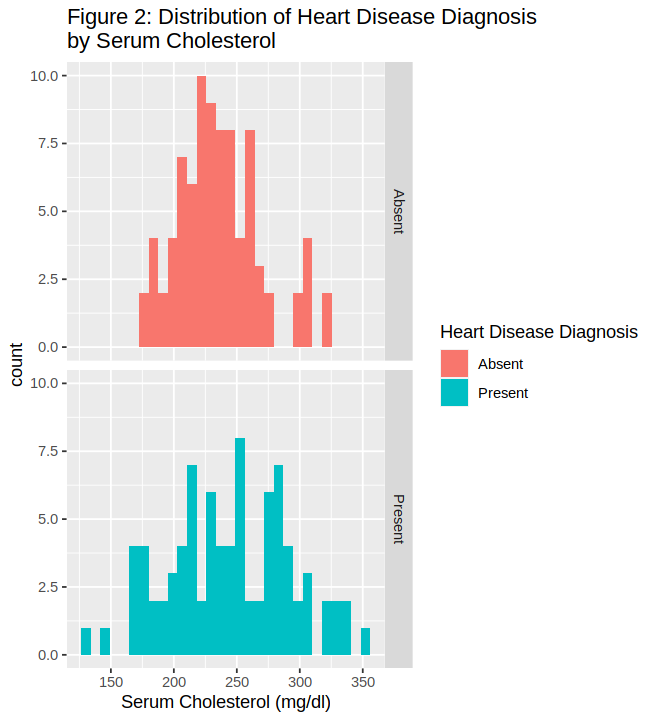

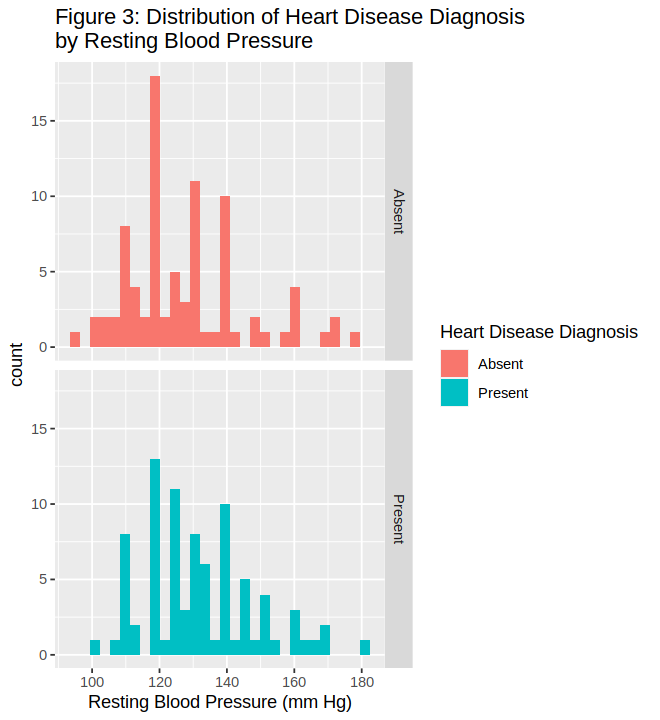

In [39]:
options(repr.plot.width = 5.5, repr.plot.height = 6)
#Distribution by age
graph_age<-data_train|>
    ggplot(aes(x=age,fill=num))+
        geom_histogram()+
    facet_grid(rows=vars(num))+
    labs(x="Age (years)",fill="Heart Disease Diagnosis")+
    ggtitle("Figure 1: Distribution of Heart Disease Diagnosis by Age")
graph_age

#Distribution by chol
graph_chol<-data_train|>
    ggplot(aes(x=chol,fill=num))+
        geom_histogram()+
    facet_grid(rows=vars(num))+
     labs(x="Serum Cholesterol (mg/dl)",fill="Heart Disease Diagnosis")+
    ggtitle("Figure 2: Distribution of Heart Disease Diagnosis \nby Serum Cholesterol")
graph_chol

#Distribution by trestbps
graph_thalach<-data_train|>
    ggplot(aes(x=trestbps,fill=num))+
        geom_histogram()+
    facet_grid(rows=vars(num))+
     labs(x="Resting Blood Pressure (mm Hg)",fill="Heart Disease Diagnosis")+
    ggtitle("Figure 3: Distribution of Heart Disease Diagnosis \nby Resting Blood Pressure")
graph_thalach

#### **2.5. Expected Outcomes and Significance**

Our model aims to predict whether an individual has heart disease using age, cholesterol, and trestbps measurements. Considering the distributions, we expect older individuals (around high 50s) with higher cholesterol (around 250 mg/dl) and higher resting blood pressure (high 130s bps) to have heart disease, and younger individuals with lower cholesterol and resting blood pressure to be absent of heart disease. These findings give doctors insight into trends for heart disease, reducing misdiagnoses and wasted resources, which helps patients lengthen their lives by receiving proper treatment.

#### **2.6. Building and Testing the Model**

Using the training data, we create a model with 'num' as the classification column and age, chol, and trestbps as predictors. Predictors are standardized to ensure one predictor is not weighed more heavily in the model, as K-nearest neighbors uses Euclidean distance and predictors are currently on different scales. Following, cross-validation of the accuracies of different values of K (1, 6, 11..., 96) is used to choose a K value.

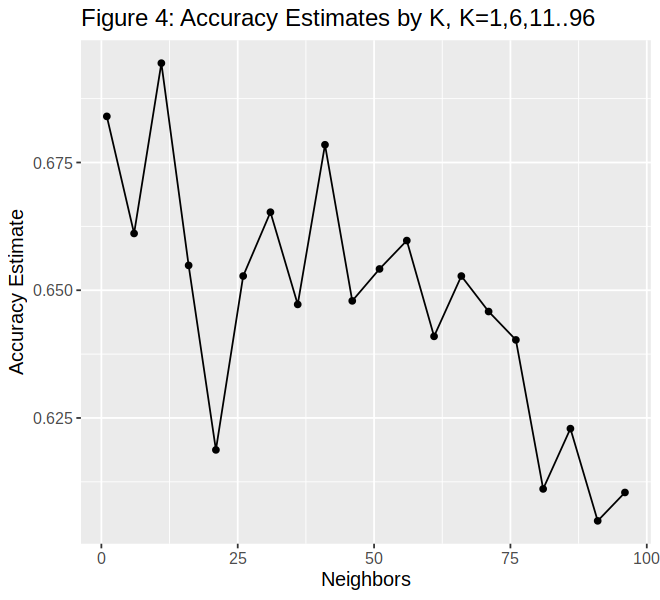

In [40]:
#Standardizing the data 
cleveland_recipe <- recipe(num ~., data = data_train)|> 
step_scale(all_predictors()) |> 
step_center(all_predictors()) 

#Creating the specification model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
set_engine("kknn") |> 
set_mode("classification") 

#Cross Validation
set.seed(9)
cleveland_vfold <- vfold_cv(data_train, v = 10, strata = num) 

#K values to test
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5)) 

#Tuning the model for each value of K
knn_results <- workflow() |> 
add_recipe(cleveland_recipe) |> 
add_model(knn_spec) |> 
tune_grid(resamples = cleveland_vfold, grid = k_vals) |> 
collect_metrics() 

#Accuracies for each K value
accuracies <- knn_results |> 
filter(.metric == "accuracy") 

options(repr.plot.width = 5.5, repr.plot.height = 5)
#Plot of K value vs. accuracy estimate, used for choosing K
accuracy_vs_k <- accuracies|>
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() + 
    labs(x = "Neighbors", y = "Accuracy Estimate")+
    ggtitle("Figure 4: Accuracy Estimates by K, K=1,6,11..96")+
    theme(text = element_text(size = 12)) 
accuracy_vs_k

From Figure 4, we choose K=41. It is the second highest peak, meaning it has roughly optimal accuracy. However, compared to K=11 it is advantageous, as changing the K value to a nearby one doesn't decrease the accuracy as drastically, meaning K=41 is more reliable in the presence of uncertainty.

We now build a new specification and model using K=41, and test the model by making predictions on the testing data.

In [41]:
#Creating the new model with K=41
new_spec<-nearest_neighbor(weight_func = "rectangular", neighbors = 41) |> 
set_engine("kknn") |> 
set_mode("classification")

new_results <- workflow() |> 
add_recipe(cleveland_recipe) |> 
add_model(new_spec) |> 
fit(data=data_train)

#Testing the model by making predictions on the testing data
cleveland_test_predictions<-predict(new_results,data_test)|>
    bind_cols(data_test)
h4("Table 8: First 6 Rows of Predictions and Actual Classes for Testing Data")
head(cleveland_test_predictions)

Shiny tags cannot be represented in plain text (need html)

.pred_class,age,chol,trestbps,num
<fct>,<dbl>,<dbl>,<dbl>,<fct>
Absent,41,250,112,Absent
Absent,52,223,138,Absent
Absent,42,180,130,Absent
Present,63,233,145,Absent
Absent,44,226,120,Absent
Absent,52,186,118,Absent


#### **2.7 Evaluating the Model**

We evaluate the model by calculating accuracy, where accuracy is the number of correct predictions over the total number of predictions. Further, we create a confusion matrix to see how many of each case (present and absent) are predicted correctly and incorrectly. This gives us insight into the kinds of mistakes the model tends to make, which is especially important for a dataset like heart disease, where classifying present cases can have life-or-death impacts.

In [42]:
h4("Table 9: Accuracy of Model")
cleveland_test_predictions|>
    metrics(truth=num,estimate=.pred_class)|>
    filter(.metric=="accuracy")

h4("Table 10: Confusion Matrix")
confusion <- cleveland_test_predictions |>
             conf_mat(truth = num, estimate = .pred_class)
confusion

Shiny tags cannot be represented in plain text (need html)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7241379


Shiny tags cannot be represented in plain text (need html)

          Truth
Prediction Absent Present
   Absent      24      11
   Present      5      18

#### **2.8 Visualizing the Model**

To visualize the model and trends for specific predictors, we will create three scatter plots - one for each pair of predictors - with points coloured based on the predicted class of heart disease (present or absence). First, we create a table with standardized values of predictors in order to aid the graphs' readability, as the scale of visual distances can be more easily understood within the context of their impact on the K-nearest neighbors algorithm. While predictors were indeed standardized earlier for the model, that recipe was put into a workflow rather than prepped and baked. We use the latter option here to apply step_scale and step_center to obtain standardized predictors, which we can then store and represent in a table.

In [43]:
visual_recipe<-recipe(.pred_class~age+chol+trestbps,data=cleveland_test_predictions)|>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()

visual_data<-bake(visual_recipe,cleveland_test_predictions)
h4("Table 11: Test Predictions with Standardized Predictors")
head(visual_data)

Shiny tags cannot be represented in plain text (need html)

age,chol,trestbps,.pred_class
<dbl>,<dbl>,<dbl>,<fct>
-1.4614788,0.2523890,-0.9629227,Absent
-0.2248429,-0.5509467,0.4776402,Absent
-1.3490573,-1.8303333,0.0343901,Absent
1.0117930,-0.2534150,0.8654841,Present
-1.1242144,-0.4616872,-0.5196726,Absent
-0.2248429,-1.6518143,-0.6304851,Absent


The values in Table 11 are used to create the aforementioned visualizations.

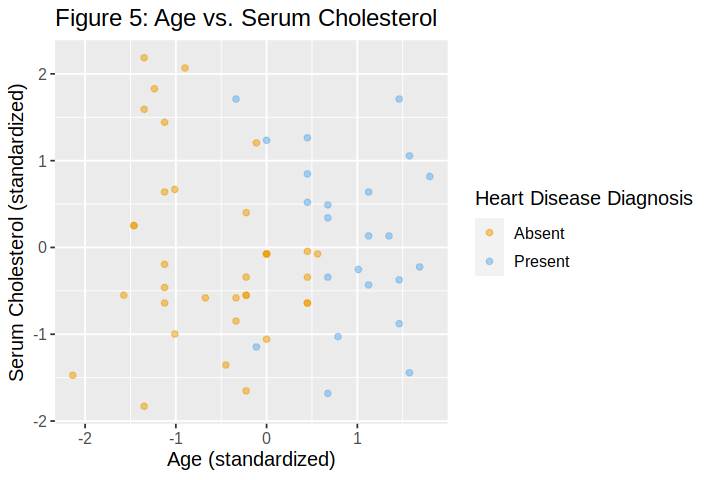

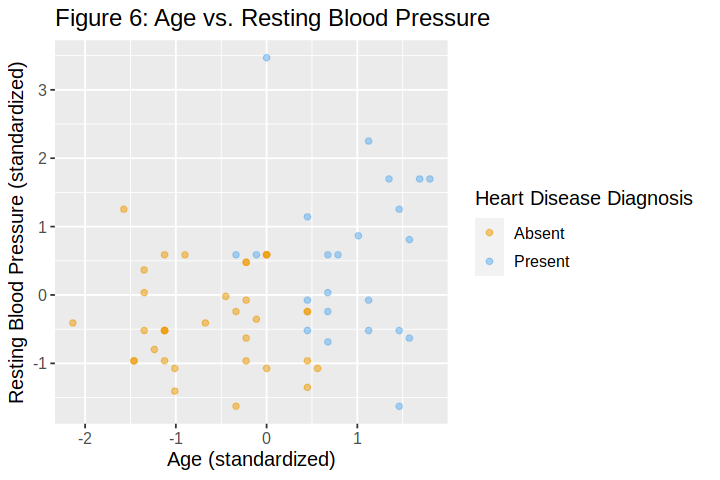

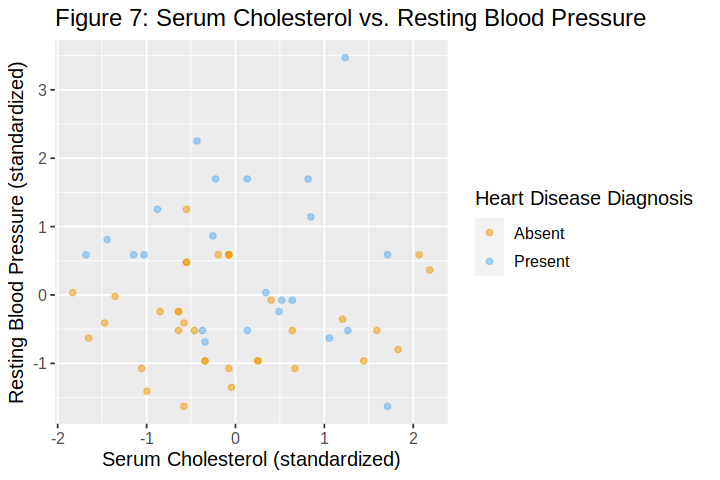

In [44]:
options(repr.plot.height=4,repr.plot.width=6)

#Age vs. Serum Cholesterol
age_chol_plot <- visual_data |>
  ggplot(aes(x = age, y = chol, color = .pred_class)) +
  geom_point(alpha = 0.5) +
  labs(x = "Age (standardized)", 
       y = "Serum Cholesterol (standardized)",
       color = "Heart Disease Diagnosis") +
ggtitle("Figure 5: Age vs. Serum Cholesterol")+
  scale_color_manual(values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))
age_chol_plot

#Age vs. Resting Blood Pressure
age_trestbps_plot <- visual_data |>
  ggplot(aes(x = age, y = trestbps, color = .pred_class)) +
  geom_point(alpha = 0.5) +
  labs(x = "Age (standardized)", 
       y = "Resting Blood Pressure (standardized)",
       color = "Heart Disease Diagnosis") +
ggtitle("Figure 6: Age vs. Resting Blood Pressure")+
  scale_color_manual(values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))
age_trestbps_plot

#Serum Cholesterol vs. Resting Blood Pressure
chol_trestbps_plot <- visual_data |>
  ggplot(aes(x = chol, y = trestbps, color = .pred_class)) +
  geom_point(alpha = 0.5) +
  labs(x = "Serum Cholesterol (standardized)", 
       y = "Resting Blood Pressure (standardized)",
       color = "Heart Disease Diagnosis") +
ggtitle("Figure 7: Serum Cholesterol vs. Resting Blood Pressure")+
  scale_color_manual(values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))
chol_trestbps_plot

### **3. Discussion**

We found that the accuracy of predicting heart disease using the predictors age, serum cholesterol and resting blood pressure was 72.41%, which is an improvement from the majority classifier’s accuracy of 50% (as the data contains 50% present and 50% absent cases). However, our data set is focused on heart disease, which involves life-or-death scenarios. Therefore, this model would require higher accuracy in order to be used effectively in health care settings. Its inaccuracies may be due to the context of the problem; only three predictors were utilized here, though in reality diagnoses are made from more quantitative and qualitative factors and a doctor’s expertise.

This conclusion is furthered by calculations of precision and recall. We define present as the positive label, as we are more interested in identifying these cases due to their life-or-death implications. Precision is calculated as the number of correct positive predictions over the total number of positive predictions, or 18/(18+5)=0.7826. This tells us that if our model reports a new observation is positive, it will be positive 78.26% of the time, which is relatively strong and important in allocating expensive resources towards further treatments for patients. In addition, recall is calculated as the number of correct positive predictions over the total number of positive test set observations, or 18/(18+11)=0.6207. This tells us that if there's a positive observation in the test data, the classifier finds it 62.07% of the time. This is noticeably lower, which is especially significant as failing to find a positive case may prevent the patient from receiving the treatment necessary for survival.

Further, by evaluating our data analysis graphs (Figures 5-7), we observe that as age increased, the amount of present cases increased when paired with serum cholesterol or resting blood pressure. However, no clear trend was seen for serum cholesterol and resting blood pressure. This indicates that age is a very important predictor for diagnosing heart disease, as heart disease is correlated with increasing age.

In our exploratory data analysis, we expected older individuals with higher cholesterol and higher resting blood pressure to have heart disease, and younger individuals with lower cholesterol and resting blood pressure to be absent of heart disease. These expectations matched what we found in our data, particularly for the age predictor. However, Figure 5 shows minimal differentiation between low and high cholesterol patients. While Figure 6 shows present cases to generally have slightly higher blood pressure, the difference is less than expected. Additionally, the serum cholesterol vs resting blood pressure graph had less distinct present vs absent groups than expected.

These findings give doctors more insight and evidence into trends for heart diseases. Specifically, an increase in age is one of the most important predictors of heart disease, followed by increased resting blood pressure. These conclusions help reduce misdiagnoses and may also decrease the time required for diagnoses, minimizing opportunities for the disease to worsen. This allows patients with heart diseases to receive proper treatment that is effective and provided in a timely manner, lengthening their lives. It also reduces the resources which are unnecessarily used for misdiagnosed patients.

Findings could lead to further questions, including “Could high cholesterol and high resting blood pressure be indications of other medical problems?” Follow-up investigations could also include whether treatments like lowering cholesterol or lowering resting blood pressure may help reduce the risk of heart disease as a senior.

### **4. References**

Carlén, A., Gustafsson, M., Aneq, M. Å, & Nylander, E. (2019). Exercise-induced ST depression in an asymptomatic population without coronary artery disease, Scandinavian Cardiovascular Journal, 53(4), 206-212. https://doi.org/10.1080/14017431.2019.1626021

Franklin, S.S., Larson, M.G., Khan, S.A., Wong., N.D., Leip, E.P., Kannel, W.B., & Levy, D. (2001). Does the Relation of Blood Pressure to Coronary Heart Disease Risk Change With Aging? The Framingham Heart Study Circulation, 103(9), 1245-1249. https://doi.org/10.1161/01.CIR.103.9.1245

Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

Jung, E., Kong, S. Y., Ro, Y. S., Ryu, H. H., & Shin, S. D. (2022). Serum Cholesterol Levels and Risk of Cardiovascular Death: A Systematic Review and a Dose-Response Meta-Analysis of Prospective Cohort Studies. International journal of environmental research and public health, 19(14), 8272. https://doi.org/10.3390/ijerph19148272

Perret-Guillaume, C., Joly, L., & Benetos, A. (2009). Heart Rate as a Risk Factor for Cardiovascular Disease, Progress in Cardiovascular Diseases, 52(1), 6-10. https://doi.org/10.1016/j.pcad.2009.05.003

Prabhavathi, K., Thamarai Selvi, K., Poornima, K.N., & Sarvanan, A. (2014). Role of Biological Sex in Normal Cardiac Function and in its Disease Outcome – A Review, Journal of Clinical and Diagnostic Research, 8(8), BE01-4. https://doi.org/10.7860/JCDR/2014/9635.4771

Timbers, T.-A., Campbell, T., & Lee, M. (2022). Data science: A first introduction. CRC Press, Taylor & Francis Group. 

Valentini, M., & Parati., G. (2009). Variables Influencing Heart Rate. Progress in Cardiovascular Disease, 52(1), 11-19. https://doi.org/10.1016/j.pcad.2009.05.004